Student Dropout Prediction Pipeline
----------------------------------
This notebook implements a robust, production-ready pipeline for predicting student dropout using the UCI dataset and PyCaret. It covers data cleaning, feature engineering, model training, evaluation, prediction, and feature importance extraction, with explanations for each step.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import setup, compare_models, pull, save_model, evaluate_model, predict_model, get_config, finalize_model, plot_model
import shap
import os
import json

# Key categorical mappings from variable_list.md
GENDER_MAP = {1: 'male', 0: 'female'}
MARITAL_STATUS_MAP = {
    1: 'single', 2: 'married', 3: 'widower', 4: 'divorced', 5: 'facto union', 6: 'legally separated'
}
TARGET_MAP = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}  # Adjust if actual codes differ

## Data Acquisition & Understanding
We fetch the dataset and display its structure. Understanding the data is the first step in any machine learning workflow.

Data shape: (4424, 37)
First 5 rows:


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate



Target value counts:


Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

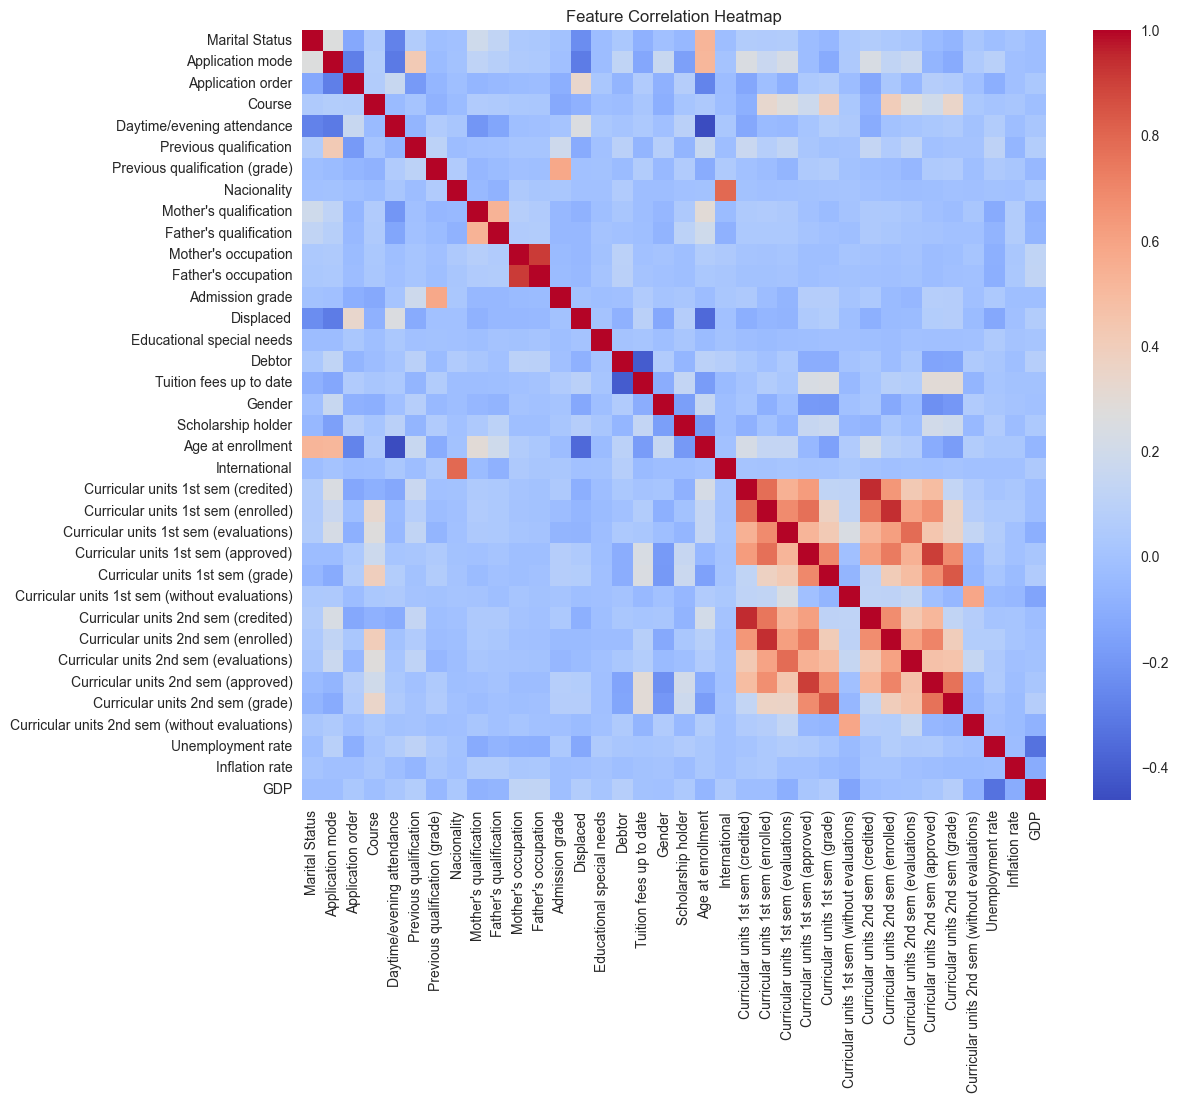

In [2]:
# Fetch the dataset
student_dropout = fetch_ucirepo(id=697)  # UCI ID for the dataset

# Use the original DataFrame with the target column for PyCaret
# If the target is not already a column, add it
if hasattr(student_dropout.data, 'original'):
    df = student_dropout.data.original.copy()
else:
    # fallback: merge features and targets
    df = pd.concat([student_dropout.data.features, student_dropout.data.targets], axis=1)

print('Data shape:', df.shape)
print('First 5 rows:')
display(df.head())

# EDA (optional, for exploration only)
print('\nTarget value counts:')
display(df['Target'].value_counts())

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.drop('Target', axis=1).corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

## Data Preprocessing - Consistent Feature Names
To avoid errors and ensure reproducibility, we standardize feature names and ensure all required features are present. This is critical for robust pipelines and model deployment.

In [3]:
def standardize_feature_names(df):
    """Ensure consistent feature naming across entire pipeline"""
    df = df.copy()
    # PyCaret's default name cleaning rules:
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('/', '_')
                 .replace('(', '').replace(')', '').replace("'", "").strip()
                 for col in df.columns]
    return df

# Apply to original data
df_clean = standardize_feature_names(df)

# Verify all expected features are present
required_features = [
    'Marital_Status', 'Application_mode', 'Application_order', 'Course',
    'Daytime_evening_attendance', 'Previous_qualification',
    'Previous_qualification_grade', 'Nacionality',
    'Mothers_qualification', 'Fathers_qualification',
    'Mothers_occupation', 'Fathers_occupation', 'Admission_grade',
    'Displaced', 'Educational_special_needs', 'Debtor',
    'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
    'Age_at_enrollment', 'International',
    'Curricular_units_1st_sem_credited',
    'Curricular_units_1st_sem_enrolled',
    'Curricular_units_1st_sem_evaluations',
    'Curricular_units_1st_sem_approved',
    'Curricular_units_1st_sem_grade',
    'Curricular_units_1st_sem_without_evaluations',
    'Curricular_units_2nd_sem_credited',
    'Curricular_units_2nd_sem_enrolled',
    'Curricular_units_2nd_sem_evaluations',
    'Curricular_units_2nd_sem_approved',
    'Curricular_units_2nd_sem_grade',
    'Curricular_units_2nd_sem_without_evaluations',
    'Unemployment_rate', 'Inflation_rate', 'GDP'
]

# Ensure all features are present
missing_features = [f for f in required_features if f not in df_clean.columns]
if missing_features:
    print(f"Warning: {len(missing_features)} features missing. Adding with default values.")
    for f in missing_features:
        df_clean[f] = 0  # Or appropriate default value

## Model Development with Consistent Features
We set up PyCaret with the cleaned data, enabling feature selection, multicollinearity removal, and class imbalance correction. This step prepares the data and environment for robust model training.

In [4]:
# Setup environment with cleaned data
exp = setup(
    data=df_clean,
    target='Target',
    session_id=42,
    fold_strategy='stratifiedkfold',
    fold=5,
    feature_selection=True,
    remove_multicollinearity=True,
    fix_imbalance=True,
    verbose=False
)

# Train and finalize model
best_model = compare_models(sort='F1')
final_model = finalize_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7190,0.0000,0.7190,0.7207,0.7171,0.5372,0.5397,1.0380
lightgbm,Light Gradient Boosting Machine,0.7161,0.8603,0.7161,0.7086,0.7105,0.5299,0.5318,0.8540
rf,Random Forest Classifier,0.7099,0.8611,0.7099,0.7088,0.7077,0.5232,0.5246,0.7240
et,Extra Trees Classifier,0.7077,0.8565,0.7077,0.7071,0.7049,0.5180,0.5204,0.6620
ada,Ada Boost Classifier,0.6899,0.0000,0.6899,0.7151,0.6987,0.5041,0.5070,0.6060
lr,Logistic Regression,0.6718,0.0000,0.6718,0.7218,0.6864,0.4859,0.4942,2.2100
nb,Naive Bayes,0.6583,0.8055,0.6583,0.6926,0.6644,0.4496,0.4578,1.4160
ridge,Ridge Classifier,0.6502,0.0000,0.6502,0.6951,0.6631,0.4457,0.4521,0.5220
qda,Quadratic Discriminant Analysis,0.6541,0.0000,0.6541,0.6658,0.6551,0.4346,0.4381,0.5260
lda,Linear Discriminant Analysis,0.6263,0.0000,0.6263,0.7073,0.6484,0.4258,0.4404,0.5240


## Consistent Evaluation and Visualization
We evaluate the finalized model using confusion matrix, class report, and feature importance plots. This provides insight into model performance and areas for improvement.

In [5]:
# Wrapper function for consistent evaluation
def safe_evaluation(model, data=None):
    """Handle feature name consistency during evaluation"""
    if data is not None:
        data = standardize_feature_names(data)
        # Ensure all training features exist
        for f in required_features:
            if f not in data.columns and f != 'Target':
                data[f] = 0
    try:
        # Plot confusion matrix
        plot_model(model, plot='confusion_matrix', save=True)
        # Plot class report
        plot_model(model, plot='class_report', save=True)
        # Plot feature importance
        plot_model(model, plot='feature', save=True)
        print("All evaluations completed successfully")
    except Exception as e:
        print(f"Evaluation error: {str(e)}")
        # Fallback to SHAP feature importance
        import shap
        # Extract the underlying estimator from the pipeline
        if hasattr(model, 'steps'):
            estimator = model.steps[-1][1]
        else:
            estimator = model
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(df_clean.drop('Target', axis=1))
        shap.summary_plot(shap_values, df_clean.drop('Target', axis=1), show=False)
        plt.savefig('feature_importance_fallback.png')
        plt.close()

# Run evaluations
safe_evaluation(final_model)

All evaluations completed successfully


## SHAP Analysis with Feature Consistency

In [6]:
def run_shap_analysis(model, data):
    """Run SHAP analysis with feature name handling"""
    data_clean = standardize_feature_names(data)
    X = data_clean.drop('Target', axis=1)
    # Ensure all features exist
    for f in required_features:
        if f not in X.columns and f != 'Target':
            X[f] = 0
    try:
        import shap
        # Extract the underlying estimator from the pipeline
        if hasattr(model, 'steps'):
            estimator = model.steps[-1][1]
        else:
            estimator = model
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X)
        # Summary plot
        plt.figure(figsize=(12, 8))
        if isinstance(shap_values, list):
            for i, sv in enumerate(shap_values):
                shap.summary_plot(sv, X, show=False)
                plt.title(f'SHAP Summary - Class {i}')
                plt.tight_layout()
                plt.savefig(f'shap_class_{i}.png', dpi=300)
                plt.close()
        else:
            shap.summary_plot(shap_values, X, show=False)
            plt.tight_layout()
            plt.savefig('shap_summary.png', dpi=300)
            plt.close()
        # Export values
        if isinstance(shap_values, list):
            for i, sv in enumerate(shap_values):
                pd.DataFrame(sv, columns=X.columns).to_csv(f'shap_values_class_{i}.csv')
        else:
            pd.DataFrame(shap_values, columns=X.columns).to_csv('shap_values.csv')
    except Exception as e:
        print(f"SHAP failed: {str(e)}")

run_shap_analysis(final_model, df)

SHAP failed: GradientBoostingClassifier is only supported for binary classification right now!


## Model Tuning & Finalization
We save the finalized model and required features for production use. This ensures reproducibility and enables future predictions on new data.

In [7]:
# Ensure model_outputs directory exists
os.makedirs('model_outputs', exist_ok=True)

# Save the final model in the proper directory
save_model(final_model, 'model_outputs/final_student_dropout_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Marital_Status',
                                              'Application_mode',
                                              'Application_order', 'Course',
                                              'Daytime_evening_attendance',
                                              'Previous_qualification',
                                              'Previous_qualificati...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
                                             max_depth=3, max_features=None,
              

In [8]:
# 5. When making predictions, ensure same preprocessing
def predict_with_clean_features(model, data):
    """Wrapper function to ensure consistent feature names and all required features present"""
    data_clean = standardize_feature_names(data)
    for col in required_features:
        if col not in data_clean.columns and col != 'Target':
            data_clean[col] = 0  # Or appropriate default/imputation
    # Reorder columns to match training
    feature_cols = [col for col in required_features if col in data_clean.columns]
    if 'Target' in data_clean.columns:
        feature_cols.append('Target')
    data_clean = data_clean[[col for col in data_clean.columns if col in feature_cols]]
    return predict_model(model, data=data_clean)

# 6. Usage example: predict on original data (or replace with new data)
predictions = predict_with_clean_features(final_model, df)
display(predictions[['Target', 'prediction_label', 'prediction_score']].head())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7575,0.9030,0.7575,0.7564,0.7539,0.5983,0.6014


,Target,prediction_label,prediction_score
0,Dropout,Dropout,0.7161
1,Graduate,Graduate,0.9125
2,Dropout,Dropout,0.9011
3,Graduate,Graduate,0.5574
4,Graduate,Graduate,0.8202


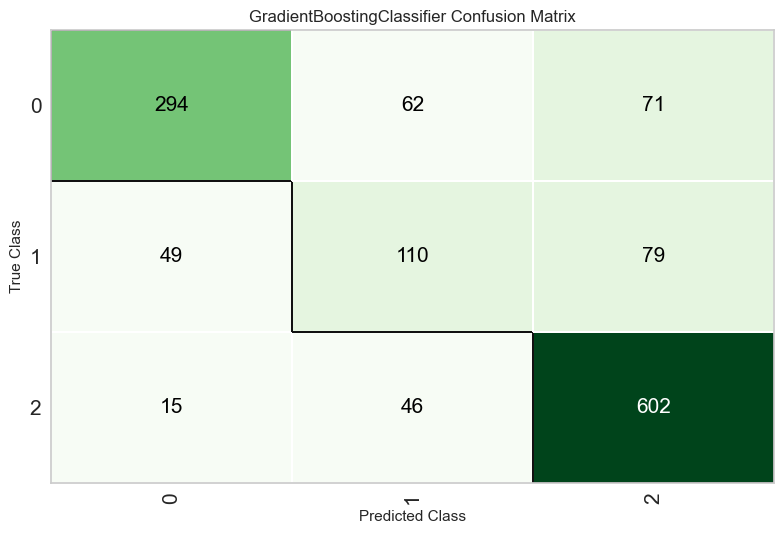

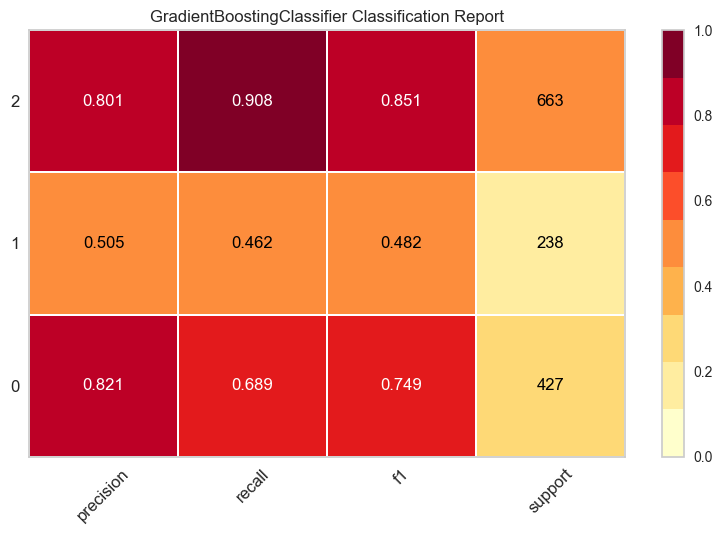

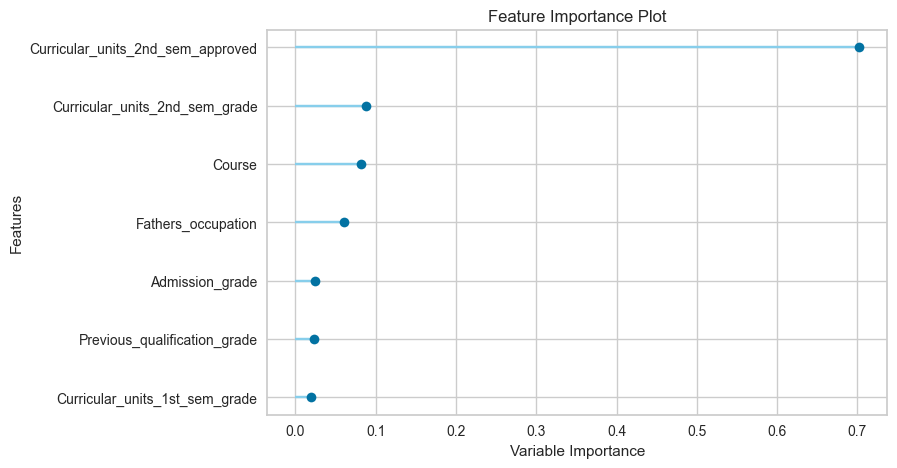

Successfully exported permutation importance


In [9]:
# Generate classification report
plot_model(final_model, plot='confusion_matrix')
plot_model(final_model, plot='class_report')
plot_model(final_model, plot='feature')

# Save required features for production in the same directory
with open('model_outputs/model_features.json', 'w') as f:
    json.dump(required_features, f)

# After model finalization, export feature importances
try:
    # Get the pipeline including preprocessing steps
    pipeline = final_model
    
    # Get the preprocessed data
    X_test = get_config('X_test')
    y_test = get_config('y_test')
    
    # Calculate permutation importance on the pipeline (including preprocessing)
    from sklearn.inspection import permutation_importance
    result = permutation_importance(
        pipeline, 
        X_test, 
        y_test, 
        n_repeats=10, 
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    # Get the feature names after preprocessing
    used_features = X_test.columns
    
    # Create and save importance dataframe
    importance_df = pd.DataFrame({
        'feature': used_features,
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False)
    
    importance_df.to_csv('model_outputs/feature_importance.csv', index=False)
    print("Successfully exported permutation importance")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=importance_df.head(20),
        palette='viridis'
    )
    plt.title('Top 20 Most Important Features (Permutation Importance)')
    plt.tight_layout()
    plt.savefig('model_outputs/feature_importance_plot.png', dpi=300)
    plt.close()
    
except Exception as e:
    print(f"Failed to calculate feature importance: {str(e)}")
    # Fallback to simple feature importance if available
    if hasattr(estimator, 'feature_importances_'):
        try:
            importance_df = pd.DataFrame({
                'feature': used_features[:len(estimator.feature_importances_)],
                'importance': estimator.feature_importances_
            }).sort_values('importance', ascending=False)
            importance_df.to_csv('model_outputs/feature_importance_fallback.csv', index=False)
            print("Exported simple feature importance as fallback")
        except:
            print("Could not export any feature importance metrics")

## Prediction with Clean Features
We define a function to preprocess new data and make predictions using the finalized model, ensuring consistency with the training pipeline.

In [10]:
# 5. When making predictions, ensure same preprocessing
def predict_with_clean_features(model, data):
    """Wrapper function to ensure consistent feature names and all required features present"""
    data_clean = standardize_feature_names(data)
    for col in required_features:
        if col not in data_clean.columns and col != 'Target':
            data_clean[col] = 0  # Or appropriate default/imputation
    # Reorder columns to match training
    feature_cols = [col for col in required_features if col in data_clean.columns]
    if 'Target' in data_clean.columns:
        feature_cols.append('Target')
    data_clean = data_clean[[col for col in data_clean.columns if col in feature_cols]]
    return predict_model(model, data=data_clean)

# 6. Usage example: predict on original data (or replace with new data)
predictions = predict_with_clean_features(final_model, df)
display(predictions[['Target', 'prediction_label', 'prediction_score']].head())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7575,0.9030,0.7575,0.7564,0.7539,0.5983,0.6014


,Target,prediction_label,prediction_score
0,Dropout,Dropout,0.7161
1,Graduate,Graduate,0.9125
2,Dropout,Dropout,0.9011
3,Graduate,Graduate,0.5574
4,Graduate,Graduate,0.8202


## Feature Importance Extraction
We use permutation importance to robustly estimate feature importances, saving both a CSV and a plot. If permutation importance fails, we fall back to native feature importances if available. This step helps interpret the model and guide future feature engineering.

In [11]:
# After model finalization, export feature importances
try:
    # Get the pipeline including preprocessing steps
    pipeline = final_model
    
    # Get the preprocessed data
    X_test = get_config('X_test')
    y_test = get_config('y_test')
    
    # Calculate permutation importance on the pipeline (including preprocessing)
    from sklearn.inspection import permutation_importance
    result = permutation_importance(
        pipeline, 
        X_test, 
        y_test, 
        n_repeats=10, 
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    # Get the feature names after preprocessing
    used_features = X_test.columns
    
    # Create and save importance dataframe
    importance_df = pd.DataFrame({
        'feature': used_features,
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False)
    
    importance_df.to_csv('model_outputs/feature_importance.csv', index=False)
    print("Successfully exported permutation importance")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=importance_df.head(20),
        palette='viridis'
    )
    plt.title('Top 20 Most Important Features (Permutation Importance)')
    plt.tight_layout()
    plt.savefig('model_outputs/feature_importance_plot.png', dpi=300)
    plt.close()
    
except Exception as e:
    print(f"Failed to calculate feature importance: {str(e)}")
    # Fallback to simple feature importance if available
    if hasattr(estimator, 'feature_importances_'):
        try:
            importance_df = pd.DataFrame({
                'feature': used_features[:len(estimator.feature_importances_)],
                'importance': estimator.feature_importances_
            }).sort_values('importance', ascending=False)
            importance_df.to_csv('model_outputs/feature_importance_fallback.csv', index=False)
            print("Exported simple feature importance as fallback")
        except:
            print("Could not export any feature importance metrics")

Successfully exported permutation importance
